In [7]:
import torch 
import random
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from PIL import Image 

In [8]:
seed = 12345
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Instantiate the Neural Network Architecture

In [9]:
# model 1 architecture 
class NeuralNetwork1(nn.Module):

    def __init__(self): 
        super().__init__()

        # new_shape = (input size - kernel size)/padding + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5) # (12, 28, 28)
        self.pool = nn.MaxPool2d(2, 2) # (12, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5) #(24, 10, 10)
        # pooling will be done again reshaping the size to (24, 5, 5)
        self.dropout = nn.Dropout(0.25) # define the dropout
        self.fc1 = nn.Linear(24*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) # first convolution layer
        x = self.pool(F.relu(self.conv2(x))) # second convolution layer
        x = torch.flatten(x,1) # flatten the size to feed into fc layer
        x = F.relu(self.fc1(x)) # first fc layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # second fc layer
        x = self.dropout(x)
        x = self.fc3(x) # output layer
        return x

class NeuralNetwork2(nn.Module):

    def __init__(self): 
        super().__init__()

        # new_shape = (input size - kernel size)/padding + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4) # (12, 29, 29)
        self.pool = nn.MaxPool2d(2, 2) # (12, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4) #(24, 11, 11)
        # pooling will be done again reshaping the size to (24, 5, 5)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=4) # (48, 2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(48*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) # first convolution layer
        x = self.pool(F.relu(self.conv2(x))) # second convolution layer
        x = F.relu(self.conv3(x)) # third convolution layer
        x = torch.flatten(x,1) # flatten the size to feed into fc layer
        x = F.relu(self.fc1(x)) # first fc layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # second fc layer
        x = self.dropout(x)
        x = self.fc3(x) # output layer
        return x
    
# model 2 architecture 
class NeuralNetwork3(nn.Module):

    def __init__(self): 
        super().__init__()

        # new_shape = (input size - kernel size)/padding + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3) # (12, 30, 30)
        self.pool = nn.MaxPool2d(2, 2) # (12, 15, 15)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3) #(24, 13, 13)
        # pooling will be done again reshaping the size to (24, 6, 6)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3) # (48, 4, 4)
        # pooling will be done again reshaping the size to (48, 2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(48*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) # first convolution layer
        x = self.pool(F.relu(self.conv2(x))) # second convolution layer
        x = self.pool(F.relu(self.conv3(x))) # third convolution layer
        x = torch.flatten(x,1) # flatten the size to feed into fc layer
        x = F.relu(self.fc1(x)) # first fc layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # second fc layer
        x = self.dropout(x)
        x = self.fc3(x) # output layer
        return x

Define the helper functions for training and validation

In [10]:
def train_one_epoch(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    total_correct = 0
    total_size = 0
    for batch, data in enumerate(train_loader):
        optimizer.zero_grad()
        batch_loss, batch_correct, batch_size = train_one_batch(model, data, optimizer)
        total_loss += batch_loss
        total_correct += batch_correct
        total_size += batch_size
    # print(f'Training Acc: {(total_correct/total_size) *100:3f}')
    return total_loss/len(train_loader), round((total_correct/total_size) *100,3)
    
def train_one_batch(model, data, optimizer):
    correct = 0 
    samples_size = 0
    optimizer.zero_grad()
    inputs, labels = data
    outputs = model(inputs)
    loss = F.cross_entropy(outputs, labels)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    samples_size += labels.size(0)
    loss.backward()
    optimizer.step()
    return loss, correct, samples_size

def validate_one_epoch(model, test_loader):
    model.eval()
    total_loss = 0 
    total_correct = 0
    total_size = 0 
    for batch, data in enumerate(test_loader):
        with torch.no_grad():
            inputs, labels = data
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_size += labels.size(0)
            total_correct += (predicted ==labels).sum().item()
        total_loss += loss
    # print(f'Val Acc: {(total_correct/total_size) *100:3f}')
    return total_loss/len(test_loader), round((total_correct/total_size) *100,3)

def train_validate_model(model, optimizer, epochs, train_loader, test_loader):
    training_loss, validation_loss = [], []   
    for epoch in tqdm(range(1, epochs+1), desc='Training & Validating Model'): 
        # training the model for one epoch
        temp_train_loss, train_acc = train_one_epoch(model, optimizer, train_loader)
        training_loss.append(temp_train_loss.detach().item())

        # evluate the model after training epoch
        temp_val_loss, val_acc = validate_one_epoch(model, test_loader)
        validation_loss.append(temp_val_loss.detach().item())

    return training_loss, validation_loss, train_acc, val_acc

def plot_train_val_loss(training_loss, validation_loss, epochs, title):
    x = range(1, epochs+1)
    plt.plot(x, training_loss, label='Training Loss')
    plt.plot(x, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title}')
    plt.legend()
    plt.grid()
    plt.savefig(f"plots/{title.split('[')[0]}.jpeg")
    plt.show()
    return None

def train_models(model, epochs, train_loader, test_loader, model_name):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    training_loss, validation_loss, train_acc, val_acc = train_validate_model(model, optimizer, epochs, train_loader, test_loader)
    # save model weights 
    torch.save(model.state_dict(), f'models/{model_name}.pth')
    # plot train val plot for model 
    plot_train_val_loss(training_loss, validation_loss, epochs, title=f'{model_name} [Train Acc: {train_acc}%, Val Acc: {val_acc}%]')
    return


In [11]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 32, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Training & Validating Model: 100%|██████████| 50/50 [16:28<00:00, 19.76s/it]


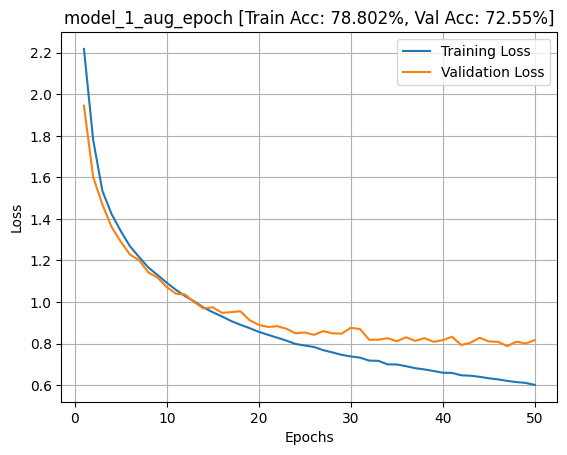

Training & Validating Model: 100%|██████████| 50/50 [16:33<00:00, 19.88s/it]


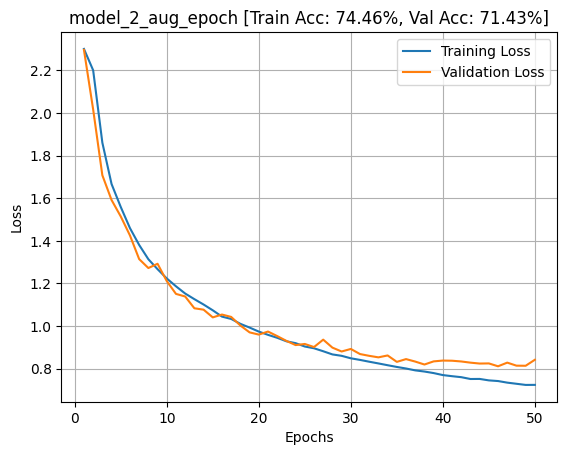

Training & Validating Model: 100%|██████████| 50/50 [16:36<00:00, 19.94s/it]


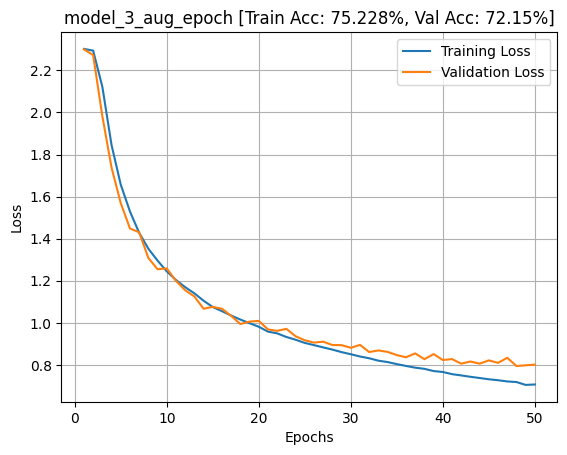

In [13]:
epochs = 50

# models intantiation
model1 = NeuralNetwork1()
model2 = NeuralNetwork2()
model3 = NeuralNetwork3()

# models training
train_models(model1, epochs, train_loader, test_loader, model_name='model_1_aug_epoch')
train_models(model2, epochs, train_loader, test_loader, model_name='model_2_aug_epoch')
train_models(model3, epochs, train_loader, test_loader, model_name='model_3_aug_epoch')

Model 1: 2 conv layer with kernel size 5 (no data augmentation, no regularization)

Model 2: 3 conv layer with kernel size 4 (no data augmentation, no regularization)

Model 3: 3 conv layer with kernel size 3 (no data augmentation, no regularization)

In [94]:
# model = NeuralNetwork()
# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# for epoch in range(40):
#     print(f'Training Epoch {epoch+1}')
#     running_loss = 0.0

#     for idx, data in enumerate(train_loader):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = model(inputs)

#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#     print(f'Running Loss : {running_loss/len(train_loader):.4f}')

In [95]:
# # save the model weights
# torch.save(model.state_dict(),  'train_model_3conv_no_reg.pth')

# # reinstantiate the model 
# model = NeuralNetwork()
# model.load_state_dict(torch.load( 'train_model_3conv_no_reg.pth'))

# # evaluate the model 
# correct = 0
# total = 0 

# model.eval() # set the model to evaluation mode

# with torch.no_grad():
#     for data in test_loader: 
#         images, labels = data
#         outputs = model(images)
#         _, prediction = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (prediction==labels).sum().item()

# accuracy = 100 * correct/total
# print(f'Model Accuracy: {accuracy}')